# 0.0 Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, auc, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import requests

import scikitplot as skplt

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from scipy.stats import chi2_contingency

import pickle

import time

from IPython.display import Image

tempo_agora = time.time() # Contabilizando o tempo de processamento do projeto

ModuleNotFoundError: No module named 'scikitplot'

###### 0.1 Loading dataset

In [2]:
# reading csv
df_raw = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\bank_churn_predict\\data\\raw\\churn.csv')
test_raw = df_raw.sample(frac=0.2, random_state=101)
test_index = test_raw.index
test = test_raw.copy()
df = df_raw.drop(test_index)
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


###### 0.3 Helper functions

In [3]:
# identificando outliers
def busca_outliers(df, series):
    q1 = np.percentile(df[series], 25)
    q3 = np.percentile(df[series], 75)
    distancia = q3 - q1
    salto = distancia * 1.5
    li = q1 - salto
    ls = q3 + salto
    indices = df[(df[series]<li)|(df[series]>ls)].index
#     print(f'O limite inferior é: {li}\nO limite superior é: {ls}\nHá {len(indices)} outliers')
    return indices, li, ls


# categorical attributes correlations
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    return round(np.sqrt((chi2corr/n)/( min(kcorr-1, rcorr-1))), 2)


def gain_curve_ktop_precision(df, model_name, dict_ktop_precision, target_variable, ktop=2000, new_clients=127000):
    proportional = df.shape[0] / new_clients
    ktop_proportional = ktop * proportional
    df.sort_values('propencity', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['ranking'] = df.index + 1
    df[f'cum_{target_variable}'] = np.cumsum(df[target_variable])
    df[f'percent_cum_{target_variable}'] = df[f'cum_{target_variable}'] / df['ranking']
    answer = round(float(df.loc[df['ranking']>=ktop_proportional, f'percent_cum_{target_variable}'].head(1).values)*100, 2)
    dict_ktop_precision[model_name] = answer
#     print(f"Precision at {ktop}ktop: {answer}%")
    return dict_ktop_precision


def gain_curve_ktop_recall(df, model_name, dict_ktop_recall, target_variable, ktop=2000, new_clients=127000):
    proportional = df.shape[0] / new_clients
    ktop_proportional = ktop * proportional
    df.sort_values('propencity', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['ranking'] = df.index + 1
    df[f'cum_{target_variable}'] = np.cumsum(df[target_variable])
    df[f'percent_cum_{target_variable}'] = df[f'cum_{target_variable}'] / df[target_variable].sum()
    answer = round(float(df.loc[df['ranking']>=ktop_proportional, f'percent_cum_{target_variable}'].head(1).values)*100, 2)
    dict_ktop_recall[model_name] = answer
#     print(f"Recall at {ktop}ktop: {answer}%")
    return dict_ktop_recall

    
def gain_curve_recall_recall(df, model_name, dict_top_recall_recall, target_variable, recall=0.8, new_clients=127000):
    proportional = df.shape[0] / new_clients
    df.sort_values('propencity', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['ranking'] = df.index + 1
    df[f'cum_{target_variable}'] = np.cumsum(df[target_variable])
    df[f'percent_cum_{target_variable}'] = df[f'cum_{target_variable}'] / df[target_variable].sum()
    answer = int(df.loc[df[f'percent_cum_{target_variable}']>=recall, 'ranking'].head(1).values/proportional)
    dict_top_recall_recall[model_name] = answer
#     print(f"To achieve {round(recall*100, 2)}% of recall: {answer} will be needed")
    return dict_top_recall_recall
    
    
def cross_validation(X_smote, y_smote, error, kfold, model_name, model):
    kf = KFold(kfold, shuffle=True)
    accuracy, precision, recall, f1 = [], [], [], []

    for train_index, test_index in kf.split(X_smote):
        # cross validation folds
        X_train, X_val = X_smote[train_index], X_smote[test_index]
        y_train, y_val = y_smote[train_index], y_smote[test_index]

        # fiting
        model_fit_kf = model.fit(X_train, y_train)

        # predicting
        y_hat = model_fit_kf.predict(X_val)

        # metrics
        accuracy.append(accuracy_score(y_val, y_hat))
        precision.append(precision_score(y_val, y_hat))
        recall.append(recall_score(y_val, y_hat))
        f1.append(f1_score(y_val, y_hat))

    accuracy.append(f'{round(np.mean(accuracy), 2)} +/- {round(np.std(accuracy), 3)}')
    precision.append(f'{round(np.mean(precision), 2)} +/- {round(np.std(precision), 3)}')
    recall.append(f'{round(np.mean(recall), 2)} +/- {round(np.std(recall), 3)}')
    f1.append(f'{round(np.mean(f1), 2)} +/- {round(np.std(f1), 3)}')

    cross_validation = pd.DataFrame([accuracy, precision, recall, f1], columns='fold1 fold2 fold3 fold4 fold5 mean_and_std'.split(), index='accuracy precision recall f1'.split()).round(2).T

    error[model_name] = cross_validation.loc['mean_and_std']
    return cross_validation, error


def metrics(X, X_smote, y_smote, X_train_smote, y_train_smote, X_val, y_val, model):
    
    # fiting val model
    model_fit = model.fit(X_train_smote, y_train_smote)
    
    # predicting val
    y_hat = model_fit.predict(X_val)
    
    # validation
    print('TRAIN')
    print(classification_report(y_val, y_hat))
    print('')

    # fiting model integral
    model_fit = model.fit(X_smote, y_smote)

    # predicting test
    y_hat = model_fit.predict(X_test)
    
    # test
    print('TEST')
    print(classification_report(y_test, y_hat))
    
    # predict proba
    predict_proba_train = model_fit.predict_proba(X)
    predict_proba_test = model_fit.predict_proba(X_test)
    
    return predict_proba_train, predict_proba_test

# 1.0 Data Description

In [4]:
df1 = df.copy()

## 1.1 Looking dataset

In [5]:
df1.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1.2 Data dimensions

In [6]:
print(f'O dataset possui: {df1.shape[0]} linhas')
print(f'O dataset possui: {df1.shape[1]} colunas')

O dataset possui: 8000 linhas
O dataset possui: 14 colunas


## 1.3 Datatypes

In [7]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 1.4 Cheking NaN values

In [8]:
df1.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 1.5 Descriptive Statistical

### 1.5.1 Classifying Attributes

In [9]:
cat_attributes = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Tenure', 'Gender', 'Geography']
num_attributes = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

### 1.5.2 Numerical Attributes

In [10]:
# Central tendency
ct1 = pd.DataFrame(df1[num_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(df1[num_attributes].apply(np.median)).T

# Dispersion
d1 = pd.DataFrame(df1[num_attributes].apply(np.std)).T
d2 = pd.DataFrame(df1[num_attributes].apply(min)).T
d3 = pd.DataFrame(df1[num_attributes].apply(max)).T
d4 = pd.DataFrame(df1[num_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df1[num_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1[num_attributes].apply(lambda x: x.kurtosis())).T

# Concat
temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
CreditScore,350.00,850.00,500.00,650.918375,652.000,96.549675,-0.081188,-0.426630
Age,18.00,92.00,74.00,38.782125,37.000,10.493077,1.049614,1.546493
Balance,0.00,250898.09,250898.09,76827.860287,97442.755,62283.923395,-0.150535,-1.477921
EstimatedSalary,11.58,199970.74,199959.16,100274.703841,100721.370,57687.654564,-0.004446,-1.184357


1. CreditScore - média e mediana próximas, o que indica que os dados estão centralizados na média, a skew é baixa e negativa, o que reforça que os dados estejam centralizados na média com uma cauda esquerda levemente maior, kurtosis pouco negativo, o que sugere uma distribuição mais plana do que uma distribuição normal com mesma média e desvio padrão.
2. Age - somente maiores de 18 anos, média e mediana levemente deslocados (10%), skew baixa e positiva, indicando que os dados estão centralizados na média com uma cauda direita levemente maior, kurtosis baixa, características de uma NORMAL
3. Balance - mínimo em zero, média e mediana bastante deslocados, desvio padrão bastante alto, skew baixa, o que sugere uma distribuição centralizada na média apesar da média e mediana diferirem, kurtosis negativa, o que sugere uma distribuição mais plana.
4. EstimatedSalary - média e mediana próximas, desvio padrão bastante alto, skew centralizado na média, kurtosis baixa, distribuição mais plana do que uma normal.

### 1.5.3 Categorical Attributes

In [11]:
df1[cat_attributes].apply(lambda x: x.nunique())

NumOfProducts      4
HasCrCard          2
IsActiveMember     2
Tenure            11
Gender             2
Geography          3
dtype: int64

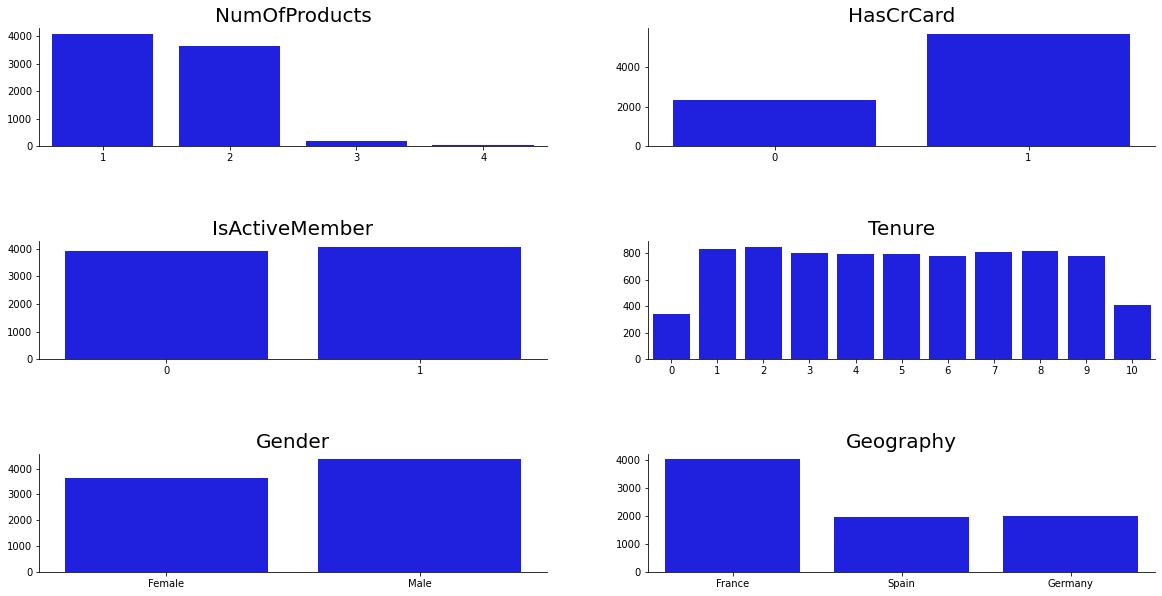

In [12]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.8)

plt.subplot(3, 2, 1)
sns.countplot(data=df1, x='NumOfProducts', color='b')
sns.despine()
plt.title('NumOfProducts', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(3, 2, 2)
sns.countplot(data=df1, x='HasCrCard', color='b')
sns.despine()
plt.title('HasCrCard', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(3, 2, 3)
sns.countplot(data=df1, x='IsActiveMember', color='b')
sns.despine()
plt.title('IsActiveMember', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(3, 2, 4)
sns.countplot(data=df1, x='Tenure', color='b')
sns.despine()
plt.title('Tenure', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(3, 2, 5)
sns.countplot(data=df1, x='Gender', color='b')
sns.despine()
plt.title('Gender', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(3, 2, 6)
sns.countplot(data=df1, x='Geography', color='b')
sns.despine()
plt.title('Geography', fontsize=20)
plt.xlabel('')
plt.ylabel('');

1. Maior parte dos clientes com 1 ou 2 produtos
2. Clientes com cartão de crédito são maioria]
3. Clientes na França são maioria

# 2.0 Feature Engineering

In [13]:
df2 = df1.copy()

# 3.0 Exploratory Data Analysis

In [14]:
df3 = df2.copy()

##### Main insights:

###### Exited
1. Desbalanceado, por volta de 20% de churn
2. Correlação fraca com Age e muito fraca com as demais

###### NumOfProducts
1. Clientes com 3 ou 4 produtos têm maior probabilidade de churn, com 80% e 100% de churn respectivamente.
2. Correlação fraca negativa com Balance
3. 95% dos clientes possuem 1 ou 2 produtos

###### HasCrCard
1. 70% dos clientes possuem cartão de crédito
2. Aparentemente não ajuda a modelar o fenômeno
3. Correlações muito fracas

###### IsActiveMember
1. A quantidade de clientes ativos e inativos está equilibrada
2. Membros ativos são 47% menos propensos ao churn
3. Correlações muito fracas

###### Geography
1. Mais de 50% dos clientes está na França
2. Clientes da Germany têm maior probabilidade de churn
3. Correlações muito fracas

###### Gender
1. 54% dos clientes são homens
2. Mulheres têm 34% de chance maior de churn
3. Correlações muito fracas

###### CreditScore
1. Não há faixas de CreditScore mais suscetíveis ao churn
2. Correlações muito fracas
3. Há um teto máximo de score, distribuição semelhante a uma Poisson
4. Outliers somente no início da distribuição

###### Age
1. Idade mínima de 18 anos, máxima de 92, aparentemente sem erros de input
2. Média de idade de clientes em churn é de 45, já os em não churn é de 37
3. Correlação fraca com Exited
4. Cauda direita mais pesada
5. 359 outliers pelo método de Tukey

###### Balance
1. Balance com valor máximo bastante mais alto do que o terceiro quartil, indicando outliers. Com primeiro quartil com cliantes com valor zerado na conta, o que sugere que haja uma quantidade grande de contas com zero de saldo.
2. Clientes com saldo zerado na conta tem probabilidade relativamente menor de churn
3. Excluindo-se as contas de valores de Balance zerados, resta uma curva aparentemente normal com média em 12000
3. Correlação fraca com NumOfProducts
4. 36% das contas bancárias estão zeradas
5. Excluindo-se as contas com Balance igual a zero, pelo método de Tukey há 73 outliers

###### EstimatedSalary
1. Aparentemente não ajuda a modelar o fenômeno
2. Correlações muito fracas
3. Apresenta uma contagem bastante contínua em todo o range da variância da feature, semelhante a variáveis categóricas

###### Tenure
1. Aparentemente não ajuda a modelar o fenômeno
2. Correlações muito fracas
3. Apesar das médias de churn por categoria serem relativamente diferentes, os desvios padrões colocam todas as categorias em um mesmo patamar

## 3.1 Business Hypothesis

### 3.1.1 Hypothesis Mindmap

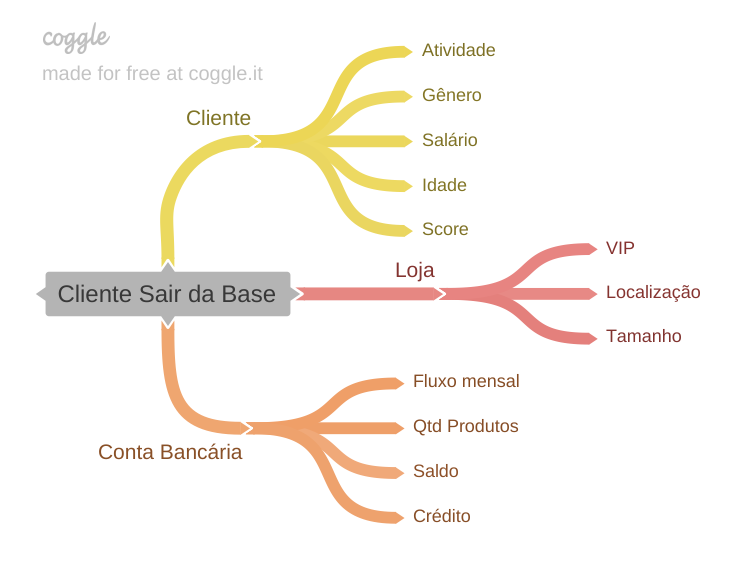

In [15]:
Image('..\\img\\mindmap.png')

### 3.1.2 Creating Hypothesis

###### Clientes:
1. Clientes mais ativos deveriam fazer menos churn.
2. Mulheres deveriam fazer menos churn.
3. Clientes com salários maiores deveriam fazer mais churn.
4. Clientes mais velhos deveriam fazer menos churn.
5. Clientes com melhores scores deveriam fazer mais churn

###### Conta Bancária:
1. Clientes com contas bancárias com maiores movimentações mensais deveriam fazer menos churn.
2. Clientes que adquirem mais produtos deveriam fazer menos churn.
3. Clientes com saldos bancários maiores deveriam fazer menos churn.
4. Clientes com cartão de crédito deveriam fazer menos churn.

###### Loja:
1. Lojas especiais VIPs deveriam ter menos churn.
2. Lojas melhor localizadas deveriam ter menos churn.
3. Lojas maiores deveriam ter menos churn.
4. Lojas localizadas em países com melhores PIB's deveriam vender mais.

###### Lista Final de Hipóteses:
As hipóteses em negrito foram selecionadas e serão estudadas primeiro. O principal critério para selecionar as possíveis hipóteses foi a disponibilidade de features que possibilitem os estudos.

1. Clientes mais ativos deveriam fazer menos churn.
2. Mulheres deveriam fazer menos churn.
3. Clientes com salários maiores deveriam fazer mais churn.
4. Clientes mais velhos deveriam fazer menos churn.
5. Clientes com melhores scores deveriam fazer mais churn
6. Clientes com contas bancárias com maiores movimentações mensais deveriam fazer menos churn.
7. Clientes que adquirem mais produtos deveriam fazer menos churn.
8. Clientes com saldos bancários maiores deveriam fazer menos churn.
9. Clientes com cartão de crédito deveriam fazer menos churn.

## 3.2 Univariate Analysis

### 3.2.1 Response Variable

Média de churn: 20.18%


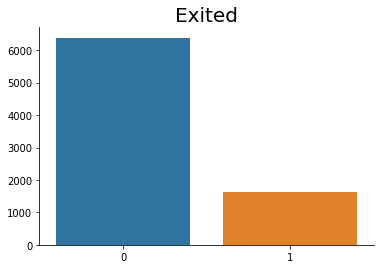

In [16]:
sns.countplot(data=df3, x='Exited')
sns.despine()
plt.title('Exited', fontsize=20)
plt.xlabel('')
plt.ylabel('')
print(f"Média de churn: {round(df['Exited'].mean()*100, 2)}%")

### 3.2.2 Numerical Variables

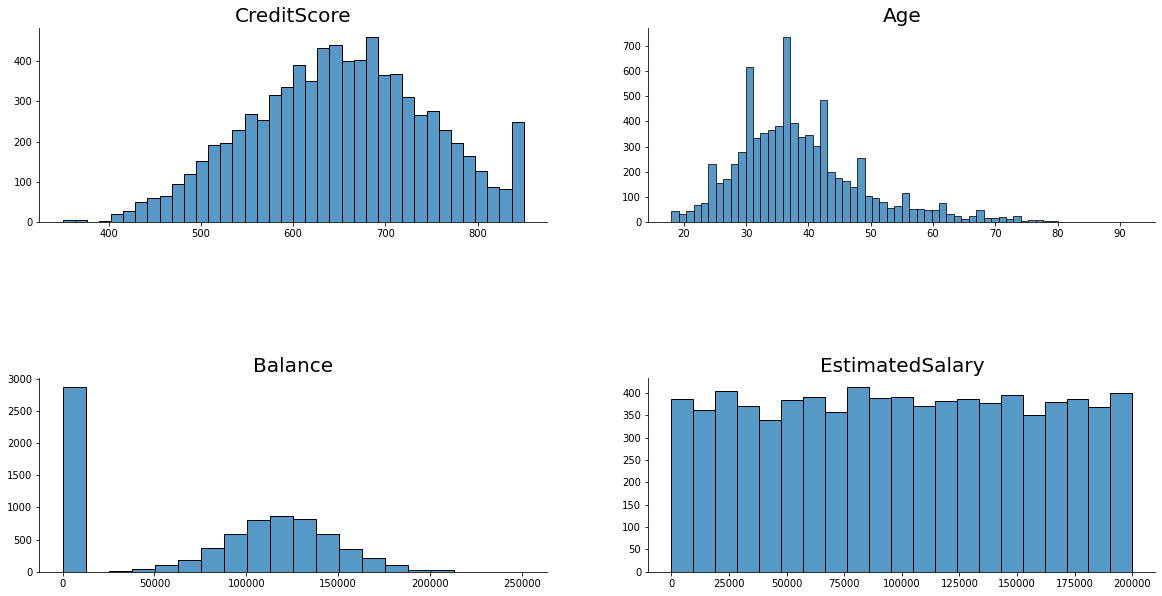

In [17]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.8)

plt.subplot(2, 2, 1)
indices, li, ls = busca_outliers(df3, 'CreditScore')
temp = df3.loc[indices]
sns.histplot(data=df3, x='CreditScore')
sns.despine()
plt.title('CreditScore', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
indices, li, ls = busca_outliers(df3, 'Age')
temp = df3.loc[indices]
sns.histplot(data=df3, x='Age')
sns.despine()
plt.title('Age', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
indices, li, ls = busca_outliers(df3, 'Balance')
temp = df3.loc[indices]
sns.histplot(data=df3, x='Balance')
sns.despine()
plt.title('Balance', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
indices, li, ls = busca_outliers(df3, 'EstimatedSalary')
temp = df3.loc[indices]
sns.histplot(data=df3, x='EstimatedSalary')
sns.despine()
plt.title('EstimatedSalary', fontsize=20)
plt.xlabel('')
plt.ylabel('');

1. Muitas contas zeradas
2. Salário estimado com uma distribuição totalmente plana

### 3.2.3 Categorical Variables

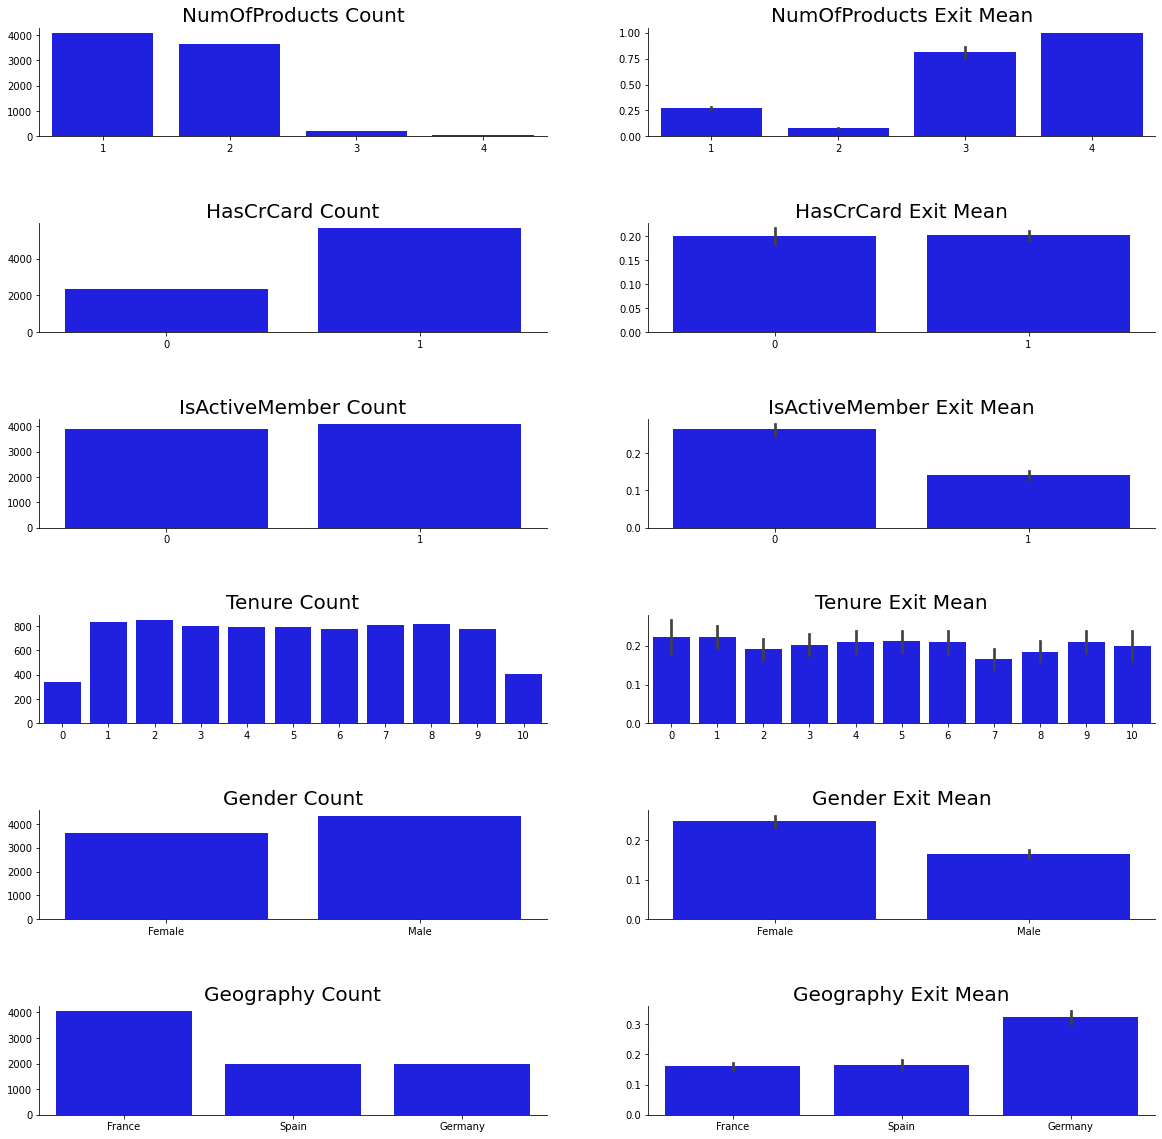

In [18]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.8)

plt.subplot(6, 2, 1)
sns.countplot(data=df3, x='NumOfProducts', color='b')
sns.despine()
plt.title('NumOfProducts Count', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 2)
sns.barplot(data=df3, x='NumOfProducts', y='Exited', color='b')
sns.despine()
plt.title('NumOfProducts Exit Mean', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 3)
sns.countplot(data=df3, x='HasCrCard', color='b')
sns.despine()
plt.title('HasCrCard Count', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 4)
sns.barplot(data=df3, x='HasCrCard', y='Exited', color='b')
sns.despine()
plt.title('HasCrCard Exit Mean', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 5)
sns.countplot(data=df3, x='IsActiveMember', color='b')
sns.despine()
plt.title('IsActiveMember Count', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 6)
sns.barplot(data=df3, x='IsActiveMember', y='Exited', color='b')
sns.despine()
plt.title('IsActiveMember Exit Mean', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 7)
sns.countplot(data=df3, x='Tenure', color='b')
sns.despine()
plt.title('Tenure Count', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 8)
sns.barplot(data=df3, x='Tenure', y='Exited', color='b')
sns.despine()
plt.title('Tenure Exit Mean', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 9)
sns.countplot(data=df3, x='Gender', color='b')
sns.despine()
plt.title('Gender Count', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 10)
sns.barplot(data=df3, x='Gender', y='Exited', color='b')
sns.despine()
plt.title('Gender Exit Mean', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 11)
sns.countplot(data=df3, x='Geography', color='b')
sns.despine()
plt.title('Geography Count', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(6, 2, 12)
sns.barplot(data=df3, x='Geography', y='Exited', color='b')
sns.despine()
plt.title('Geography Exit Mean', fontsize=20)
plt.xlabel('')
plt.ylabel('');

###### 1. Clientes mais ativos deveriam fazer menos churn.
Hipótese validada, clientes mais ativos fazem menos churn
###### 2. Mulheres deveriam fazer menos churn.
Hipótese refutada, mulheres fazem mais churn
###### 7. Clientes que adquirem mais produtos deveriam fazer menos churn.
Hipótese refutada, clientes que adquirirem mais produtos fazem mais churn
###### 9. Clientes com cartão de crédito deveriam fazer menos churn.
Hipótese refutada, cartão de crédito aparentemente é indiferente para o churn

## 3.3 Bivariate Analysis

###### 3.3.1 Clientes com salários maiores deveriam fazer mais churn.
Hipótese refutada, salário aparentemente não influencia no churn

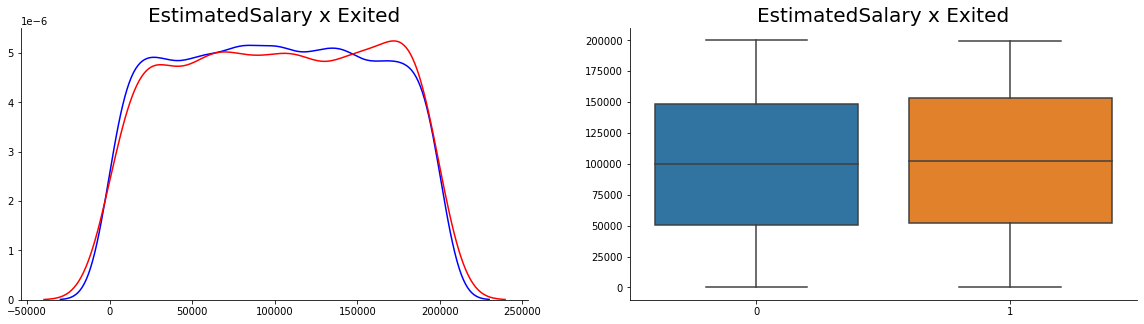

In [19]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(data=df3.loc[df3['Exited']==0], x='EstimatedSalary', color='b')
sns.kdeplot(data=df3.loc[df3['Exited']==1], x='EstimatedSalary', color='r')
sns.despine()
plt.title('EstimatedSalary x Exited', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.boxplot(data=df3, y='EstimatedSalary', x='Exited')
sns.despine()
plt.title('EstimatedSalary x Exited', fontsize=20)
plt.xlabel('')
plt.ylabel('');

###### 3.3.2. Clientes mais velhos deveriam fazer menos churn.
Hipótese refutada, clientes mais velhos fazem mais churn

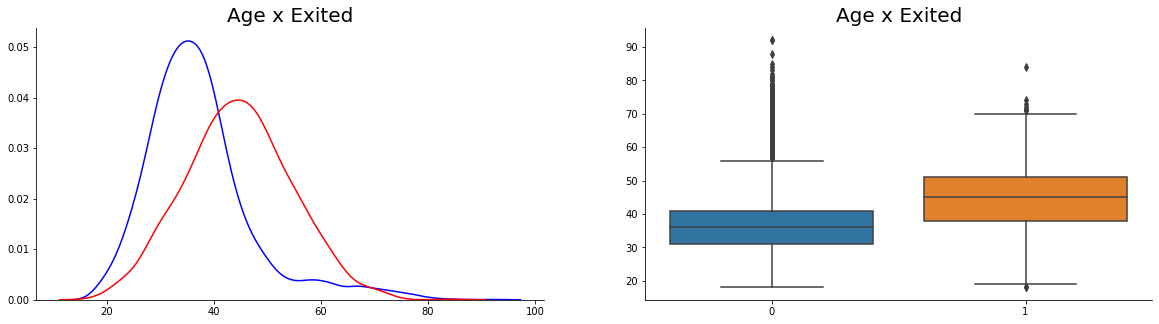

In [20]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(data=df3.loc[df3['Exited']==0], x='Age', color='b')
sns.kdeplot(data=df3.loc[df3['Exited']==1], x='Age', color='r')
sns.despine()
plt.title('Age x Exited', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.boxplot(data=df3, y='Age', x='Exited')
sns.despine()
plt.title('Age x Exited', fontsize=20)
plt.xlabel('')
plt.ylabel('');

In [21]:
print(f"Média de clientes que permanecem na base: {int(df3.loc[df3['Exited']==0, 'Age'].mean())}")
print(f"Média de clientes em churn: {int(df3.loc[df3['Exited']==1, 'Age'].mean())}")

Média de clientes que permanecem na base: 37
Média de clientes em churn: 44


A distribuição de idade entre os clientes que fizeram ou não churn é bastante diferente. A média de clientes que fazem churn está acima do terceiro quartil dos clientes que não fizeram churn.

###### 3.3.3. Clientes com melhores scores deveriam fazer mais churn
Hipótese refutada, score aparentemente não influencia no churn

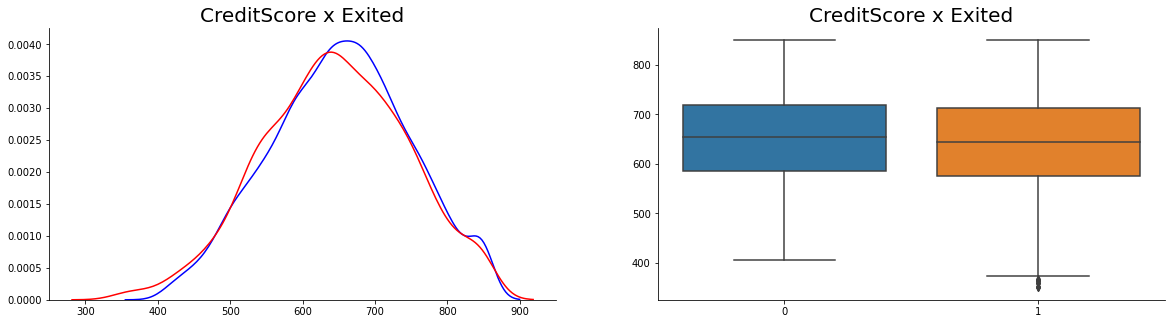

In [22]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(data=df3.loc[df3['Exited']==0], x='CreditScore', color='b')
sns.kdeplot(data=df3.loc[df3['Exited']==1], x='CreditScore', color='r')
sns.despine()
plt.title('CreditScore x Exited', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.boxplot(data=df3, y='CreditScore', x='Exited')
sns.despine()
plt.title('CreditScore x Exited', fontsize=20)
plt.xlabel('')
plt.ylabel('');

###### 3.3.4. Clientes com saldos bancários maiores deveriam fazer menos churn.
Hipótese refutada, clientes com mais dinheiro na conta fazem mais churn.

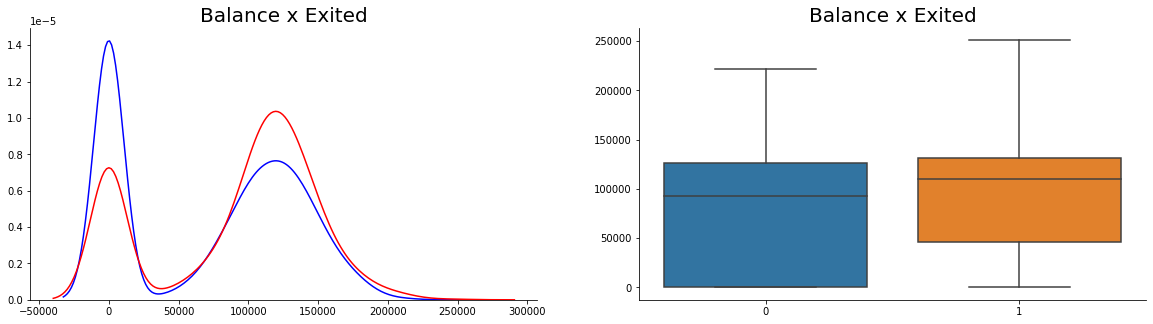

In [23]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(data=df3.loc[df3['Exited']==0], x='Balance', color='b')
sns.kdeplot(data=df3.loc[df3['Exited']==1], x='Balance', color='r')
sns.despine()
plt.title('Balance x Exited', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.boxplot(data=df3, y='Balance', x='Exited')
sns.despine()
plt.title('Balance x Exited', fontsize=20)
plt.xlabel('')
plt.ylabel('');

## 3.4 Multivariate Analysis

### 3.4.1 Numerical Attributes

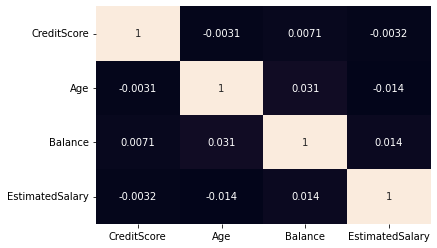

In [24]:
sns.heatmap(df3[num_attributes].corr(), annot=True, cbar=False);

### 3.4.2 Categorical Attributes

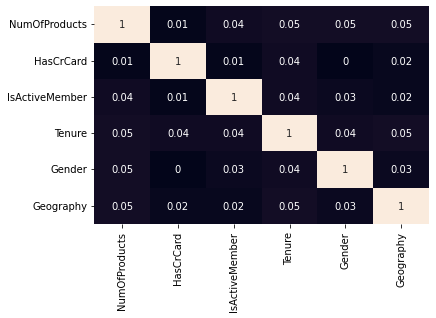

In [25]:
cramer_correlation = []

for i, col_1 in enumerate(cat_attributes):
    for j, col_2 in enumerate(cat_attributes):
        cramer_correlation.append(cramer_v(df3[col_1], df3[col_2]))
        
matrix = pd.DataFrame(np.array(cramer_correlation).reshape(6, 6), index=cat_attributes, columns=cat_attributes)

sns.heatmap(matrix, annot=True, cbar=False);

# 4.0 Data Filtering

In [26]:
df4 = df3.copy()

## 4.1 Columns Filtering

In [27]:
cols_filtering = ['Surname']
df4.drop(cols_filtering, axis=1, inplace=True)

## 4.2 Rows Filtering

# 5.0 Data Preparation

In [28]:
df5 = df4.copy()

## 5.1 Normalization

In [29]:
# 'Balance'
ss_balance = StandardScaler()
ss_balance = ss_balance.fit(df5[['Balance']].values)
df5['Balance'] = ss_balance.transform(df5[['Balance']].values)

## 5.2 Rescaling

In [30]:
# 'CreditScore'
mm_credit_score = MinMaxScaler().fit(df5[['CreditScore']].values)
df5['CreditScore'] = mm_credit_score.transform(df5[['CreditScore']].values)

# 'EstimatedSalary'
mm_estimatedsalary = MinMaxScaler().fit(df5[['EstimatedSalary']].values)
df5['EstimatedSalary'] = mm_estimatedsalary.transform(df5[['EstimatedSalary']].values)

# 'Age'
df5['Age'] = np.log1p(df5['Age'])

## 5.3 Transformations

### 5.3.1 Encoding

In [31]:
# 'Geography'
map_geography = df5.groupby('Geography').agg({'Exited':'mean'})['Exited']
df5['Geography'] = df5['Geography'].map(map_geography)

# 'Gender'
map_gender = {'Female':0, 'Male':1}
df5['Gender'] = df5['Gender'].map(map_gender)

# 'NumOfProducts'
map_numofproducts = df5.groupby('NumOfProducts').agg({'Exited':'mean'})['Exited']
df5['NumOfProducts'] = df5['NumOfProducts'].map(map_numofproducts)

### 5.3.2 Nature Transformation

In [32]:
# 'Tenure'
tenure_cicle = df5['Tenure'].max() - df5['Tenure'].min()
df5['Tenure_sin'] = df5['Tenure'].apply(lambda x: np.sin(x* (2*np.pi/tenure_cicle)))
df5['Tenure_cos'] = df5['Tenure'].apply(lambda x: np.cos(x* (2*np.pi/tenure_cicle)))
df5.drop('Tenure', axis=1, inplace=True)

## 5.4 Splits

In [33]:
# spliting X and y
cols_drop_split = ['RowNumber', 'CustomerId', 'Exited']
X = df5.drop(cols_drop_split, axis=1).values
y = df5['Exited'].values.ravel()

# train and test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

## 5.5 Balancing

In [34]:
smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_smote, y_smote = smote.fit_resample(X, y)

## 5.6 Test Preparation

In [35]:
test_backup = test.copy()

# for next business steps
map_test_id_salary = test[['CustomerId', 'EstimatedSalary']].set_index('CustomerId')['EstimatedSalary']

test.drop(cols_filtering, axis=1, inplace=True)

test['Balance'] = ss_balance.transform(test[['Balance']].values)

test['CreditScore'] = mm_credit_score.transform(test[['CreditScore']].values)

test['EstimatedSalary'] = mm_estimatedsalary.transform(test[['EstimatedSalary']].values)

test['Age'] = np.log1p(test['Age'])

test['Geography'] = test['Geography'].map(map_geography)

test['Gender'] = test['Gender'].map(map_gender)

test['NumOfProducts'] = test['NumOfProducts'].map(map_numofproducts)

test['Tenure_sin'] = test['Tenure'].apply(lambda x: np.sin(x* (2*np.pi/tenure_cicle)))
test['Tenure_cos'] = test['Tenure'].apply(lambda x: np.cos(x* (2*np.pi/tenure_cicle)))
test.drop('Tenure', axis=1, inplace=True)

# spliting X and y
X_test = test.drop(['RowNumber', 'CustomerId', 'Exited'], axis=1).values
y_test = test['Exited'].values.ravel()

# 6.0 Feature Selection

In [36]:
df6 = df5.copy()

## 6.1 Embedded Method

### 6.1.1 Importances

In [37]:
# train

# model definition
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=100)

# fiting model
rf_fit = rf_model.fit(X_train_smote, y_train_smote)

# predicts
y_hat = rf_fit.predict(X_val)

print('train')
print(classification_report(y_val, y_hat))

# test

# fiting model
rf_fit = rf_model.fit(X_smote, y_smote)

# predicts
y_hat = rf_fit.predict(X_test)

print('test')
print(classification_report(y_test, y_hat))

train
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1265
           1       0.53      0.67      0.59       335

    accuracy                           0.81      1600
   macro avg       0.72      0.76      0.73      1600
weighted avg       0.83      0.81      0.82      1600

test
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1577
           1       0.54      0.69      0.60       423

    accuracy                           0.81      2000
   macro avg       0.72      0.76      0.74      2000
weighted avg       0.83      0.81      0.82      2000



In [38]:
cols = df6.drop(['RowNumber', 'CustomerId', 'Exited'], axis=1).columns.to_list()

importances = pd.DataFrame(rf_model.feature_importances_, index=cols, columns=['rf_importances']).sort_values('rf_importances', ascending=False).reset_index().rename(columns={'index': 'features'})
importances

,features,rf_importances
0,NumOfProducts,0.371338
1,Age,0.298721
2,Geography,0.187589
3,Balance,0.060313
4,IsActiveMember,0.045122
5,Gender,0.010907
6,EstimatedSalary,0.009938
7,CreditScore,0.006729
8,Tenure_cos,0.004933
9,Tenure_sin,0.003919


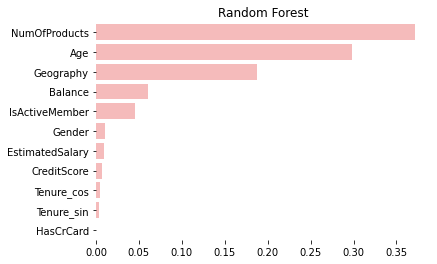

In [39]:
sns.barplot(data=importances.sort_values('rf_importances', ascending=False), x='rf_importances', y='features', color='r', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.title('Random Forest')
plt.xlabel('')
plt.ylabel('');

## 6.2 Wrapper Method

### 6.2.1 Boruta

### 6.2.2 RFE

## 6.3 Droping Features

In [40]:
cols_drop = 'Gender EstimatedSalary CreditScore Tenure_cos Tenure_sin HasCrCard'.split()

df6.drop(cols_drop, axis=1, inplace=True)

# 7.0 Machine Learning Modeling

## 7.1 Preprocessing

In [41]:
df7 = df6.copy()
error = pd.DataFrame()

# spliting X and y
X = df7.drop(['RowNumber', 'CustomerId', 'Exited'], axis=1).values
y = df7['Exited'].values.ravel()

# train and test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

# balancing
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_smote, y_smote = smote.fit_resample(X, y)

# test preparation
test = test_backup.copy()

test.drop(cols_filtering, axis=1, inplace=True)

test['Balance'] = ss_balance.transform(test[['Balance']].values)

test['CreditScore'] = mm_credit_score.transform(test[['CreditScore']].values)

test['EstimatedSalary'] = mm_estimatedsalary.transform(test[['EstimatedSalary']].values)

test['Age'] = np.log1p(test['Age'])

test['Geography'] = test['Geography'].map(map_geography)

test['Gender'] = test['Gender'].map(map_gender)

test['NumOfProducts'] = test['NumOfProducts'].map(map_numofproducts)

test['Tenure_sin'] = test['Tenure'].apply(lambda x: np.sin(x* (2*np.pi/tenure_cicle)))
test['Tenure_cos'] = test['Tenure'].apply(lambda x: np.cos(x* (2*np.pi/tenure_cicle)))
test.drop('Tenure', axis=1, inplace=True)

# feature_selection
test.drop(cols_drop, axis=1, inplace=True)

# spliting X and y
X_test = test.drop(['RowNumber', 'CustomerId', 'Exited'], axis=1).values
y_test = test['Exited'].values.ravel()

## 7.2 Logistic Regression

In [42]:
lr_model = LogisticRegression()

lr_proba_train, lr_proba_test = metrics(X, X_smote, y_smote, X_train_smote, y_train_smote, X_val, y_val, lr_model)

TRAIN
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1265
           1       0.45      0.75      0.56       335

    accuracy                           0.75      1600
   macro avg       0.68      0.75      0.70      1600
weighted avg       0.82      0.75      0.77      1600


TEST
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1577
           1       0.47      0.76      0.58       423

    accuracy                           0.77      2000
   macro avg       0.70      0.76      0.71      2000
weighted avg       0.83      0.77      0.78      2000



### 7.2.1 Logistic Regression Cross Validation

In [43]:
lr_cross_validation, error = cross_validation(X_smote, y_smote, error, 5, 'Linear Regression', lr_model)
lr_cross_validation

,accuracy,precision,recall,f1
fold1,0.75,0.76,0.74,0.75
fold2,0.76,0.76,0.74,0.75
fold3,0.76,0.76,0.75,0.75
fold4,0.74,0.75,0.74,0.74
fold5,0.73,0.73,0.72,0.72
mean_and_std,0.75 +/- 0.011,0.75 +/- 0.011,0.74 +/- 0.011,0.74 +/- 0.011


## 7.3 KNN

In [44]:
knn_model = KNeighborsClassifier()

knn_proba_train, knn_proba_test = metrics(X, X_smote, y_smote, X_train_smote, y_train_smote, X_val, y_val, knn_model)

TRAIN
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1265
           1       0.49      0.66      0.56       335

    accuracy                           0.78      1600
   macro avg       0.69      0.74      0.71      1600
weighted avg       0.81      0.78      0.79      1600


TEST
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1577
           1       0.49      0.73      0.58       423

    accuracy                           0.78      2000
   macro avg       0.70      0.76      0.72      2000
weighted avg       0.83      0.78      0.79      2000



### 7.3.1 KNN Cross Validation

In [45]:
knn_cross_validation, error = cross_validation(X_smote, y_smote, error, 5, 'K-Neighbors', knn_model)
knn_cross_validation

,accuracy,precision,recall,f1
fold1,0.81,0.8,0.83,0.82
fold2,0.83,0.83,0.84,0.83
fold3,0.83,0.82,0.85,0.83
fold4,0.81,0.8,0.84,0.81
fold5,0.81,0.8,0.84,0.82
mean_and_std,0.82 +/- 0.01,0.81 +/- 0.012,0.84 +/- 0.008,0.82 +/- 0.009


## 7.4 XGBoost

In [46]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='error')

xgb_proba_train, xgb_proba_test = metrics(X, X_smote, y_smote, X_train_smote, y_train_smote, X_val, y_val, xgb_model)

TRAIN
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1265
           1       0.65      0.59      0.62       335

    accuracy                           0.85      1600
   macro avg       0.77      0.76      0.76      1600
weighted avg       0.84      0.85      0.85      1600


TEST
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1577
           1       0.63      0.63      0.63       423

    accuracy                           0.84      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.84      0.84      0.84      2000



### 7.3.1 XGBoost Cross Validation

In [47]:
xgb_cross_validation, error = cross_validation(X_smote, y_smote, error, 5, 'XGBoost', xgb_model)
xgb_cross_validation

,accuracy,precision,recall,f1
fold1,0.89,0.9,0.87,0.89
fold2,0.89,0.91,0.88,0.9
fold3,0.9,0.91,0.87,0.89
fold4,0.89,0.91,0.88,0.89
fold5,0.88,0.89,0.86,0.88
mean_and_std,0.89 +/- 0.007,0.91 +/- 0.007,0.87 +/- 0.006,0.89 +/- 0.006


## 7.5 Random Forest Classifier

In [48]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=100)

rf_proba_train, rf_proba_test = metrics(X, X_smote, y_smote, X_train_smote, y_train_smote, X_val, y_val, rf_model)

TRAIN
              precision    recall  f1-score   support

           0       0.92      0.81      0.87      1265
           1       0.52      0.75      0.61       335

    accuracy                           0.80      1600
   macro avg       0.72      0.78      0.74      1600
weighted avg       0.84      0.80      0.81      1600


TEST
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1577
           1       0.52      0.76      0.62       423

    accuracy                           0.80      2000
   macro avg       0.72      0.79      0.74      2000
weighted avg       0.84      0.80      0.81      2000



### 7.4.1 Random Forest Cross Validation

In [49]:
rf_cross_validation, error = cross_validation(X_smote, y_smote, error, 5, 'Random Forest', rf_model)
rf_cross_validation

,accuracy,precision,recall,f1
fold1,0.79,0.8,0.78,0.79
fold2,0.8,0.81,0.8,0.81
fold3,0.8,0.8,0.8,0.8
fold4,0.79,0.8,0.78,0.79
fold5,0.81,0.82,0.8,0.81
mean_and_std,0.8 +/- 0.007,0.8 +/- 0.007,0.79 +/- 0.011,0.8 +/- 0.008


# 8.0 Model Performance

In [50]:
test['EstimatedSalary'] = test['CustomerId'].map(map_test_id_salary)
df8 = test.copy()
baseline_lengh = df8.shape[0]

## 8.1 Machine Learning Performance

In [51]:
error.T

,accuracy,precision,recall,f1
Linear Regression,0.75 +/- 0.011,0.75 +/- 0.011,0.74 +/- 0.011,0.74 +/- 0.011
K-Neighbors,0.82 +/- 0.01,0.81 +/- 0.012,0.84 +/- 0.008,0.82 +/- 0.009
XGBoost,0.89 +/- 0.007,0.91 +/- 0.007,0.87 +/- 0.006,0.89 +/- 0.006
Random Forest,0.8 +/- 0.007,0.8 +/- 0.007,0.79 +/- 0.011,0.8 +/- 0.008


O modelo escolhido para seguir para estudos sobre Business e Produção foi o XGBoost.

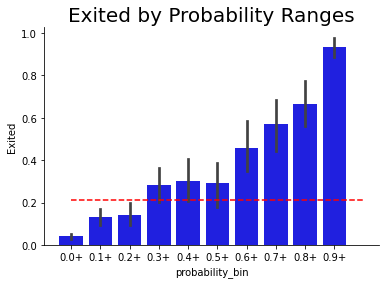

In [52]:
df8['propensity'] = xgb_proba_test[:, 1]

cols = 'CustomerId EstimatedSalary Exited propensity'.split()

df8 = df8[cols]
df8 = df8.sort_values('propensity', ascending=False)
df8['cum_exited'] = np.cumsum(df8['Exited'])
df8.reset_index(inplace=True, drop=True)
df8['ranking'] = df8.index + 1
df8['prop_base'] = df8['ranking'] / df8['ranking'].max()
df8['prop_cum_exited'] = df8['cum_exited'] / df8['cum_exited'].max()
lab = '0.0+ 0.1+ 0.2+ 0.3+ 0.4+ 0.5+ 0.6+ 0.7+ 0.8+ 0.9+'.split()
df8['probability_bin'] = pd.cut(df8['propensity'], 10, labels=lab)
df8.loc[df8['prop_base'] <= df8['Exited'].mean(), 'perfect_gain_curve'] = 1
df8['perfect_gain_curve'].fillna(0, inplace=True)
df8['perfect_gain_curve'] = np.cumsum(df8['perfect_gain_curve'])
df8['perfect_gain_curve'] = df8['perfect_gain_curve'] / df8['perfect_gain_curve'].max()

sns.barplot(data=df8, x='probability_bin', y='Exited', color='b')
sns.despine()
plt.hlines(y=df8['Exited'].mean(), xmin=0, xmax=10, color='r', linestyles='--')
plt.title('Exited by Probability Ranges', fontsize=20);

O modelo está calculando probabilidades bastante condizentes com o churn. Com uma variância bastante alta, possivelmente por conta da baixa quantidade na amostra test

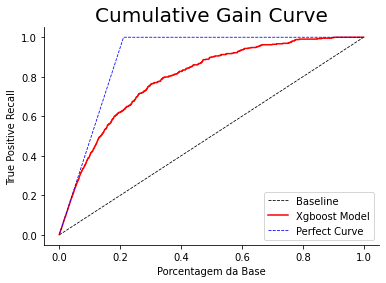

In [53]:
sns.lineplot(data=df8, x='prop_base', y='prop_base', linestyle='--', label='Baseline', color='black', linewidth=0.8)
sns.lineplot(data=df8, x='prop_base', y='prop_cum_exited', color='r', label='Xgboost Model')
sns.lineplot(data=df8, x='prop_base', y='perfect_gain_curve', color='b', label='Perfect Curve', linestyle='--', linewidth=0.8)
plt.title('Cumulative Gain Curve', fontsize=20)
sns.despine()
plt.xlabel('Porcentagem da Base')
plt.ylabel('True Positive Recall');

Variância alta. Com o dataset ranqueado por probabilidade de churn, pegando 20% do topo das amostras, conseguimos alcançar 65% de todos os clientes que fizeram churn

## 8.2 Business Performance

#### Resgras e Restrições para a Ação de Retenção:

- Clientes com propensidade de churn maior que 99% - Farão churn não importa o que se faça
- Clientes com propensidade de churn entre 95% e 99% receberão 200,00 de Gift Card
- Clientes com propensidade de churn entre 90% e 95% receberão 100,00 de Gift Card
- Clientes com propensidade de churn abaixo de 90% receberão 50,00 de Gift Card
- O total de budgit para a ação é de 10.000,00

### 8.2.1 Baseline Model Before Gift Cards

In [54]:
mean_of_churn = df['Exited'].mean()
mean_salary = df['EstimatedSalary'].mean()

baseline = test.copy()

baseline['propensity'] = xgb_proba_test[:, 1]
baseline['revenue'] = baseline['EstimatedSalary'].apply(lambda x: x * 0.15 if x <= mean_salary else x * 0.2)/12

In [55]:
basline_total_revenue = baseline['revenue'].sum()
print(f"Total Revenue before clients left: {basline_total_revenue:.2f}")

Total Revenue before clients left: 3093136.16


In [56]:
baseline_lost_revenue = baseline.loc[baseline['Exited']==1, 'revenue'].sum()
print(f"Total lost revenue after Gift Cards: {baseline_lost_revenue:.2f}")

Total lost revenue after Gift Cards: 659906.83


### 8.2.2 After Gift Cards Action trought Random Choice Methods

In [57]:
baseline['gift_card_value'] = 0

random_sample_index = baseline.sample(100).index
baseline.loc[random_sample_index, 'gift_card_value'] = 100

baseline['min_gift_card_value'] = baseline['propensity'].apply(lambda x: 200 if x >= .95 else (100 if x >= 0.9 else 50))

baseline.loc[baseline['Exited'] == 1, 'retention'] = baseline.apply(lambda x: 1 if x['gift_card_value'] - x['min_gift_card_value'] >= 0 else 0, axis=1)

baseline_total_roi = baseline.loc[baseline['retention']==1, 'revenue'].sum() - 10000

print(f'O ROI total esperado sobre {test.shape[0]} clientes: ${baseline_total_roi:.2f}')

O ROI total esperado sobre 2000 clientes: $24592.88


### 8.2.3 Scoring by Machine Learning Model and Sorting by ROI

In [58]:
df8.drop(df8.loc[df8['propensity'] >= 0.99].index, inplace=True)

df8['revenue'] = df8['EstimatedSalary'].apply(lambda x: x * 0.15 if x <= mean_salary else x * 0.2)/12
df8['gift_card_value'] = df8['propensity'].apply(lambda x: 200 if x >= .95 else (100 if x >= 0.9 else 50))
df8['roi'] = df8['revenue'] - df8['gift_card_value']
df8.sort_values('roi', ascending=False, inplace=True)
df8['cum_gift_card_value'] = np.cumsum(df8['gift_card_value'])
df8 = df8.loc[df8['cum_gift_card_value'] <= 10000]
df8['total_roi'] = np.cumsum(df8['roi'])

ml_total_roi = float(df8['total_roi'].tail(1).values)

print(f'O ROI total esperado sobre {test.shape[0]} clientes: ${ml_total_roi:.2f}')

O ROI total esperado sobre 2000 clientes: $591125.92


### 8.2.4 Business Lift

In [59]:
lift_total_roi = ml_total_roi - baseline_total_roi
prop_lift_total_roi = round(lift_total_roi / baseline_total_roi)

print(f"Em uma base com {baseline_lengh} clientes, utilizando um modelo de Machine Learning para ranquear os clientes de acordo com a sua propensão ao CHURN, e ordenando-os de acordo com o ROI, o modelo obteve um LIFT de: ${lift_total_roi:.2f} em relação à um método aleatório. O modelo foi melhor em uma razão de: {prop_lift_total_roi}X")

Em uma base com 2000 clientes, utilizando um modelo de Machine Learning para ranquear os clientes de acordo com a sua propensão ao CHURN, e ordenando-os de acordo com o ROI, o modelo obteve um LIFT de: $566533.04 em relação à um método aleatório. O modelo foi melhor em uma razão de: 23X


# 9.0 Exports

In [60]:
# cols_filtering
pickle.dump(cols_filtering, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\features\\cols_filtering.pkl', 'wb'))

# cols_drop_split
pickle.dump(cols_drop_split, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\features\\cols_drop_split.pkl', 'wb'))

# ss_balance
pickle.dump(ss_balance, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\features\\ss_balance.pkl', 'wb'))

# mm_credit_score
pickle.dump(mm_credit_score, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\features\\mm_credit_score.pkl', 'wb'))

# mm_estimatedsalary
pickle.dump(mm_estimatedsalary, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\features\\mm_estimatedsalary.pkl', 'wb'))

# map_geography
pickle.dump(map_geography, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\features\\map_geography.pkl', 'wb'))

# map_gender
pickle.dump(map_gender, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\features\\map_gender.pkl', 'wb'))

# map_numofproducts
pickle.dump(map_numofproducts, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\features\\map_numofproducts.pkl', 'wb'))

# tenure_cicle
pickle.dump(tenure_cicle, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\features\\tenure_cicle.pkl', 'wb'))

# map_test_id_salary
pickle.dump(map_test_id_salary, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\features\\map_test_id_salary.pkl', 'wb'))

# tenure_cicle
pickle.dump(tenure_cicle, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\features\\tenure_cicle.pkl', 'wb'))

# cols_drop
pickle.dump(cols_drop, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\features\\cols_drop.pkl', 'wb'))

# xgb_model
pickle.dump(xgb_model, open('D:\\My Drive\\pessoal\\projetos\\bank_churn_predict\\src\\models\\xgb_model.pkl', 'wb'))

# 10.0 API Deployed at Heroku

## 10.1 Top_bank Class

In [61]:
# import pickle
# import pandas as pd
# import numpy as np

# class Top_bank(object):
#     def __init__(self):
#         self.cols_filtering = pickle.load(open('features/cols_filtering.pkl', 'rb'))
#         self.ss_balance = pickle.load(open('features/ss_balance.pkl', 'rb'))
#         self.mm_credit_score = pickle.load(open('features/mm_credit_score.pkl', 'rb'))
#         self.mm_estimatedsalary = pickle.load(open('features/mm_estimatedsalary.pkl', 'rb'))
#         self.map_geography = pickle.load(open('features/map_geography.pkl', 'rb'))
#         self.map_gender = pickle.load(open('features/map_gender.pkl', 'rb'))
#         self.map_numofproducts = pickle.load(open('features/map_numofproducts.pkl', 'rb'))
#         self.tenure_cicle = pickle.load(open('features/tenure_cicle.pkl', 'rb'))
#         self.cols_drop = pickle.load(open('features/cols_drop.pkl', 'rb'))
#         self.cols_drop_split = pickle.load(open('features/cols_drop_split.pkl', 'rb'))
#         self.map_test_id_salary = pickle.load(open('features/map_test_id_salary.pkl', 'rb'))
#         self.model = pickle.load(open('models/xgb_model.pkl', 'rb'))

#     def data_filtering(self, df):
#         df.drop(self.cols_filtering, axis=1, inplace=True)
#         return df
        
        
#     def data_preparation(self, df):
#         df['Balance'] = self.ss_balance.transform(df[['Balance']].values)
#         df['CreditScore'] = self.mm_credit_score.transform(df[['CreditScore']].values)
#         df['EstimatedSalary'] = self.mm_estimatedsalary.transform(df[['EstimatedSalary']].values)
#         df['Age'] = np.log1p(df['Age'])
#         df['Geography'] = df['Geography'].map(self.map_geography)
#         df['Gender'] = df['Gender'].map(self.map_gender)
#         df['NumOfProducts'] = df['NumOfProducts'].map(self.map_numofproducts)
#         df['Tenure_sin'] = df['Tenure'].apply(lambda x: np.sin(x* (2*np.pi/self.tenure_cicle)))
#         df['Tenure_cos'] = df['Tenure'].apply(lambda x: np.cos(x* (2*np.pi/self.tenure_cicle)))
#         df.drop('Tenure', axis=1, inplace=True)
#         df.drop(self.cols_drop, axis=1, inplace=True)
#         df.drop(self.cols_drop_split, axis=1, inplace=True)
#         return df


#     def get_propensity(self, df, df_raw):
#         predict_proba = self.model.predict_proba(df)
#         df_raw['propensity'] = predict_proba[:, 1]
#         return df_raw

## 10.2 Handler API

In [62]:
# from flask import Flask, request, Response
# import pandas as pd
# from top_bank import Top_bank
# import os

# # initialize API
# app = Flask(__name__)

# @app.route('/predict', methods=['POST'])

# def top_bank_predict():
#     df_raw_json = request.get_json()
    
#     if df_raw_json:
#         if isinstance(df_raw_json, dict):
#             df_raw = pd.DataFrame(df_raw_json, index=[0])
            
#         else:
#             df_raw = pd.DataFrame(df_raw_json, columns=df_raw_json[0].keys())
    
#         # instantiate Top_bank_class
#         papeline = Top_bank()

#         # data_cleaning
#         df = papeline.data_filtering(df_raw)

#         # data_preparation
#         df = papeline.data_preparation(df_raw)

#         # get_propensity
#         df = papeline.get_propensity(df, df_raw)

#         # return json
#         df = df.to_json(orient='records')
#         return df
    
#     else:
#         return Response('{}', status=200, mimetype='application/json')
    
# if __name__ == '__main__':
#     # starting flask
#     port = os.environ.get('PORT', 5000) # heroku host
#     # port = 5000 # local host
#     app.run(host='0.0.0.0', port=port)

## 10.3 API Tester

In [63]:
test_raw_json = test_raw.to_json(orient='records')

# url = 'http://192.168.15.4:5000/predict'
url = 'https://api-top-bank.herokuapp.com/predict'
headers = {'Content-type':'application/json'}
data = test_raw_json

df10_json = requests.post(url=url, headers=headers, data=data)

print(f'Status request code: {df10_json.status_code}')

df = pd.DataFrame(df10_json.json(), columns=df10_json.json()[0].keys())
df.head()

Status request code: 200


,Geography,Age,Balance,NumOfProducts,IsActiveMember,propensity
0,0.164975,3.970292,-1.233510,0.075977,1,0.096832
1,0.160069,3.178054,-0.059645,0.273684,1,0.096831
2,0.160069,3.850148,-0.234660,0.273684,1,0.275503
3,0.160069,3.367296,0.608566,0.075977,1,0.063706
4,0.322938,3.850148,0.968424,0.273684,0,0.755051


# Time

In [64]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-tempo_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 0 minutos
